jupyter nbconvert final.ipynb --to pdf --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['remove_cell']" --TagRemovePreprocessor.remove_output_tags="['remove_output']" --TagRemovePreprocessor.remove_input_tags="['remove_input']"


# Introduction

In this homework we will analyze data coming from a gene expression dataset of 79 patients with leukemia belonging to two subgroups: patients with a chromosomal translocation ("1") and patients cytogenetically normal ("-1"). The *gene_expr.tsv* file contains expression for 2,000 genes and additional columns with patient labels and the outcome variable (*y*).   
The aim is to perform a supervised analysis for prediction of the subgroups using support vector machines.

In [1]:
# support libraries
import numpy as np
from matplotlib import pyplot as plt  # import subplots, cm
import sklearn.model_selection as skm
import pandas as pd
from ISLP import load_data, confusion_table

# lab-specific libraries
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from ISLP.svm import plot as plot_svm

# Methods

To classify leukemia subgroups based on gene expression, the following machine learning techniques and evaluation strategies were employed:

• **Cross-validation (CV)**: K-fold cross-validation was used to obtain robust performance estimates and prevent overfitting. This technique systematically partitions the data into training and validation sets. It was combined with grid search to optimize key hyperparameters for each SVM model type (regularization parameter *C*, *gamma* for RBF, and *degree* for polynomial)    

• **Linear support vector machine (SVM)**: This algorithm seeks the optimal **linear boundary** (hyperplane) in the high-dimensional feature space to separate the two patient classes. It aims to maximize the margin between the hyperplane and the nearest data points (support vectors) of each class.    

• **Radial basis function (RBF) SVM**: A **non-linear** SVM utilizing the RBF kernel. It implicitly maps data into a higher-dimensional space, enabling the creation of complex, curved decision boundaries. Suitable for datasets where classes are not linearly separable in the original space.   

• **Polynomial SVM**: This **non-linear** SVM employs a polynomial kernel function. It maps the input data into a higher-dimensional feature space, allowing it to find polynomial decision boundaries between classes. The degree of the polynomial controls the flexibility of the boundary.

# Data exploration and pre-processing

The analysis heavily relies on `NumPy` for numerical operations and `Pandas` for data manipulation. Core machine learning functionalities are provided by `scikit-learn`, including support vector machines (SVC), model selection tools like `GridSearchCV`, and metrics such as `RocCurveDisplay`. The `ISLP` library is utilized for specific tasks like data loading, generating confusion tables, and dedicated SVM plotting functions.

The dataset consists of 79 rows, each representing a patient, and 2002 columns, including expression measurements for 2000 genes along with two additional columns for patient labels and the outcome variable. The structure of the dataset remains unmodified, as there are no missing values that require imputation or removal.



In [2]:
dataf = pd.read_csv('gene_expr.tsv', sep='\t') #read tsv file
dataf.shape #check data set dimension

(79, 2002)

In [3]:
dataf.isnull().values.any() #check for any missing value

False

Given the nature of gene expression data, it is not unusual to observe a high dimensionality, with the number of features far exceeding the number of observations. While this characteristic can facilitate the identification of hyperplanes that effectively separate classes, it poses significant challenges for data visualization. Visualizing high-dimensional data typically necessitates dimensionality reduction techniques such as **Principal Component Analysis (PCA)**. However, by choosing not to apply these techniques, we will likely not be able to visually explore the data distribution and the hyperplanes derived from subsequent analyses.

# Linear support vector machine
To predict the presence or absence of the specific chromosomal feature via supervised learning, we employ SVMs. A **key consideration** is the dataset's high dimensionality (79 samples, 2000 genes). In such high-dimensional spaces, data points are often more easily separated by a **linear boundary**. Consequently, a linear SVM kernel is hypothesized to be effective, potentially avoiding the need for more complex RBF or polynomial kernels. This section focuses on implementing and evaluating the linear SVM. Later sections will compare its performance against the non-linear alternatives.  

As a first step, we partition the data into the feature matrix `X` (gene expressions) and the target vector `y`, which comprised 42 samples labeled *-1* and 37 samples labeled *1*, denoting the balance of the data set with respect to the outcome variable.

In [4]:
y = dataf['y'] #select only the column of outcome variable
X = dataf.drop(columns=['y', 'sampleID'], axis=1) #drop the additional columns of outcome variable and patient labels
X.shape

(79, 2000)

In [5]:
y.value_counts()

y
-1    42
 1    37
Name: count, dtype: int64

Subsequently, the dataset (both features `X` and target `y`) was manually divided into training and testing sets using an approximate **50/50** split, this splitting process is required to build the confusion matrix and the ROC curve. This resulted in a training set (`X_train`, `y_train`) containing 39 observations, comprising 21 samples labeled *-1* and 18 samples labeled *1*. The remaining 40 observations were allocated to the test set.

In [6]:
#manual split of test set and training set using skm
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape

(39, 2000)

In [7]:
y_train.value_counts()

y
 1    21
-1    18
Name: count, dtype: int64

We proceed by fitting the linear SVM model `(kernel='linear')`. For this initial fit, the regularization parameter C is set to a placeholder, as its optimal value will be determined later through a dedicated hyperparameter tuning process (cross-validation).

In [8]:
svm_linear = SVC(C=10, kernel="linear") 

We applied **10-fold cross-validation** to tune the regularization parameter 𝐶 of the linear SVM.\
In the `scikit-learn` library, cross-validation is managed using splitter generators from the `model_selection` submodule, such as the `KFold(n_splits)` class, which implements K-Fold cross-validation.\
To perform an exhaustive search over parameter values, we used the `GridSearchCV(model, param_grid, cv, ...)` function, which integrates cross-validation into the grid search process.\
By testing a pre-selected range of values, we were able to access the cross-validation metrics for each of the models stored in the attribute `grid.cv_results_`.

In [ ]:
C_values = [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1e3, 1e4]
#create a ten folds cross validation object
kfold = skm.KFold(10, random_state=0, shuffle=True)
#create the gridsearch
grid = skm.GridSearchCV(svm_linear,
                        {"C": C_values},
                        cv=kfold,
                        scoring="accuracy") #use accuracy as scoring parameter
grid.fit(X,y)
print("Optimal linear model: ", grid.best_estimator_) #best par. combination
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal linear model:  SVC(C=0.1, kernel='linear')
Cross-validation accuracy of optimal model:  0.8625


As shown above, `C=0.1` results in the highest cross-validation accuracy of **0.8625**.   
We proceeded by extracting the best model, corresponding to the optimal `C` value, stored in the attribute `best_estimator_`, and then fitting  the optimal linear SVM on the training set.

In [10]:
#access the optimal linear model
best_linear_mod = grid.best_estimator_
#fit the optimal linear model on training data
best_linear_mod.fit(X_train,y_train)

SVC(C=0.1, kernel='linear')

The cross-validation identified **C = 0.1** as the optimal choice for maximizing model performance on unseen data within the training set.\
In the last part of this section, the best linear SVM is fitted on the training data set resulting from the previous manual split. We will show the confusion matrix and the accuracy value of this model coming from our 50/50 split.

In [11]:
#prediction on test data
ypred_linear = best_linear_mod.predict(X_test)
#confusion matrix
confusion_table(ypred_linear, y_test)

Truth,-1,1
Predicted,,
-1,17,1
1,7,15


In [12]:
(ypred_linear == y_test).mean() #accuracy

0.8

The accuracy obtained on the manually separated test set is **0.8**, which is very close to the average accuracy of 0.8625 from cross-validation, confirming the model’s good generalization performance.   

In [13]:
pca = PCA(n_components=2) #initialize PCA
X_pca = pca.fit_transform(X) #fit PCA on the original dataset
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

X_train_pca = pd.DataFrame(X_train_pca) #convert transformed data into a dataframe
y_train= pd.Series(y_train).reset_index(drop=True) #reset the index of the training labels to align with the transformed training data

In [14]:
C_values = [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1e3, 1e4]
#create a ten folds cross validation object
kfold = skm.KFold(10, random_state=0, shuffle=True)
#create the gridsearch
grid = skm.GridSearchCV(svm_linear,
                        {"C": C_values},
                        cv=kfold,
                        scoring="accuracy") #use accuracy as scoring parameter
grid.fit(X_pca,y)
#access the best parameter combination
print("Optimal linear model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal linear model:  SVC(C=1000.0, kernel='linear')
Cross-validation accuracy of optimal model:  0.5446428571428571


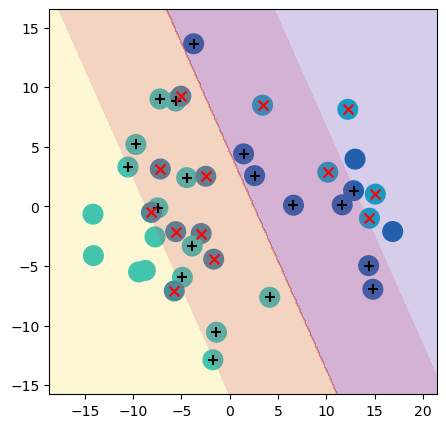

In [15]:
best_linear_mod_pca = grid.best_estimator_
best_linear_mod_pca.fit(X_train_pca,y_train)

fig, ax = plt.subplots(figsize=(5, 5))
plot_svm(X_train_pca, y_train, best_linear_mod_pca, ax=ax)

# Radial basis function and polynomial SVM

As previously mentioned, due to the nature of the dataset, a linear SVC is likely the most appropriate model for our classification problem.\
To support this assumption, in this section we fit two additional Support Vector Machines, one using an **RBF kernel** and the other using a **polynomial kernel**, and compare their performance to that of the linear SVC.\
Starting out with a radial kernel, we employed the `SVC` function with the parameter `kernel="rbf"`. Just like with the linear SVM, the two hyperparameters `C` and `gamma` were initially set to placeholder values. Then hyperparameter tuning by cross-validation was performed.

In [40]:
svm_rbf = SVC(kernel="rbf", C=1, gamma=1)

In [17]:
C_range = [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1e3, 1e4]
gamma_range = [0.5, 1, 2, 3, 4]

params = {"C": C_range, "gamma":gamma_range}

kfold = skm.KFold(10, random_state=0, shuffle=True)

grid = skm.GridSearchCV(svm_rbf, param_grid=params, cv=kfold, scoring="accuracy")
grid.fit(X_train, y_train)
print("Optimal rbf model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal rbf model:  SVC(C=0.0001, gamma=0.5)
Cross-validation accuracy of optimal model:  0.5416666666666667


In [18]:
best_rbf_svm = grid.best_estimator_
#fit the optimal linear model on training data
best_rbf_svm.fit(X_train,y_train)

SVC(C=0.0001, gamma=0.5)

In [19]:
ypred_rbf = best_rbf_svm.predict(X_test)
confusion_table(ypred_rbf, y_test)

Truth,-1,1
Predicted,,
-1,0,0
1,24,16


In [20]:
(ypred_rbf == y_test).mean() #accuracy

0.4

Our evaluation of an SVM with an RBF kernel revealed significant performance issues. The model achieved a mere **0.4** accuracy on the test set, with a correspondingly low cross-validation accuracy of **0.54**. A key diagnostic insight was the model's consistent prediction of only class 1.   
Given that prior analysis confirmed the dataset's balance, this biased output points decisively towards severe underfitting. This underfitting is attributed to the use of the smallest available values for *C* (regularization parameter) and *gamma* (kernel coefficient) within our parameter grid. Low *C* values enforce high regularization, while low *gamma* values result in a very broad, less localized kernel influence. Together, these settings likely produced an excessively smooth and overly generalized decision boundary, preventing the model from capturing the nuanced patterns required for accurate class separation.   
To address this, we transitioned to a **polynomial SVM**, implemented using SVC`(kernel="poly")`. The model's core hyperparameters, *C* and *degree*, were initially set to default/starting values. We then performed a comprehensive hyperparameter tuning process using cross-validation to identify the optimal combination for these parameters

In [21]:
svm_poly = SVC(kernel="poly", C=1, degree=2)

In [22]:
C_range = [0.1, 1, 10, 100, 1000]
degree_range = [1, 2, 3, 4]

params = {"C": C_range, "degree":degree_range}

kfold = skm.KFold(10, random_state=0, shuffle=True)

grid = skm.GridSearchCV(svm_poly, param_grid=params, cv=kfold, scoring="accuracy")
grid.fit(X_train, y_train)
grid.cv_results_
print("Optimal polynomial model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)


Optimal polynomial model:  SVC(C=0.1, degree=4, kernel='poly')
Cross-validation accuracy of optimal model:  0.7


In [23]:
best_poly_svm = grid.best_estimator_
#fit the optimal linear model on training data
best_poly_svm.fit(X_train,y_train)

SVC(C=0.1, degree=4, kernel='poly')

In [24]:
ypred_poly = best_poly_svm.predict(X_test)
confusion_table(ypred_poly, y_test)

Truth,-1,1
Predicted,,
-1,16,1
1,8,15


In [25]:
(ypred_poly == y_test).mean() #accuracy

0.775

Given the high dimensionality of gene expression data, a linear decision boundary is generally expected to perform best, as complex kernels may introduce unnecessary variance. Nonetheless, the polynomial SVM achieved an accuracy of **0.775**, together with a cross-validation accuracy of **0.7**, which, although is lower than the 0.86 obtained with the linear kernel, is still relatively high.   
This suggests that the polynomial kernel was able to capture some underlying structure in the data, though it did not provide a significant advantage over the simpler linear model. These results reinforce the suitability of the linear kernel for this classification problem.

#  Gene selection

In gene expression analysis, it is common practice to **filter out** genes with low variability, as they often contribute little to the discrimination between classes and may introduce noise into the model. To enhance signal-to-noise ratio and focus on the most informative features, we selected only the **top 5%** most variable genes based on their standard deviation across samples. This filtering step significantly reduces the dimensionality of the data while retaining the genes most likely to carry meaningful biological or predictive information.  
We then repeated the analyses from the previous section using this reduced dataset to evaluate the impact of variability-based gene selection on model performance.

In [ ]:
gene_std = X.std(axis=0) #calculate the s.d. of each gene (column-wise)
threshold = np.percentile(gene_std, 95) #compute the threshold corresponding to the 95th percentile of gene variability
top_genes = gene_std[gene_std >= threshold].index #select the genes whose s.d. is greater than or equal to the threshold
X_filtered = X[top_genes] #filter the original dataset to keep only the most variable genes (top 5%)
X_filtered.shape

(79, 100)

We proceeded exactly as before: first, we performed a **manual split** of the dataset into training and test sets. Then, we initialized the SVM models with placeholder hyperparameter values before applying cross-validation to identify the optimal parameters for each kernel.

In [27]:
#manual split of filtered training and test set using skm
X_train_f, X_test_f, y_train_f, y_test_f = skm.train_test_split(X_filtered, y, test_size=0.5, random_state=0)
y_train.value_counts()

y
 1    21
-1    18
Name: count, dtype: int64

## Linear SVM

In [28]:
svm_linear_filtered = SVC(C=10, kernel="linear")
svm_linear_filtered.fit(X_train_f,y_train_f)
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]
kfold = skm.KFold(10, random_state=0, shuffle=True)
grid = skm.GridSearchCV(svm_linear_filtered,
                        {"C": C_values},
                        cv=kfold,
                        scoring="accuracy") 
grid.fit(X_filtered,y)
#access the best parameter combination
print("Optimal linear model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal linear model:  SVC(C=0.01, kernel='linear')
Cross-validation accuracy of optimal model:  0.8339285714285714


After filtering the dataset, we observe a slight decrease in classification accuracy (from 0.86 to **0.83**). This suggests that while filtering helps reduce noise and dimensionality, it may also exclude some informative features.\
However, the optimal regularization parameter C decreased from 0.1 to **0.01**, indicating that the reduced gene set led to a cleaner, more easily separable feature space.

In [ ]:
best_linear_mod_filtered = grid.best_estimator_
best_linear_mod_filtered.fit(X_train_f,y_train_f)
ypred_linear_filtered = best_linear_mod_filtered.predict(X_test_f)
ypred_linear_filtered
confusion_table(ypred_linear_filtered, y_test_f)

Truth,-1,1
Predicted,,
-1,17,0
1,7,16


In [30]:
(ypred_linear_filtered == y_test_f).mean() # accuracy

0.825

While cross-validation (CV) favored the full feature set, a manual train-test split showed the filtered dataset achieved **higher accuracy** (0.8 to 0.825). This implies linear SVM's robustness in high dimensions benefits CV, but with fewer training samples in a single split, the reduced feature space likely prevented overfitting and improved generalization. This is reinforced by **ROC** analysis, where the filtered dataset achieved a superior AUC (0.95 vs. 0.91), indicating better discriminative power on the manually split data.

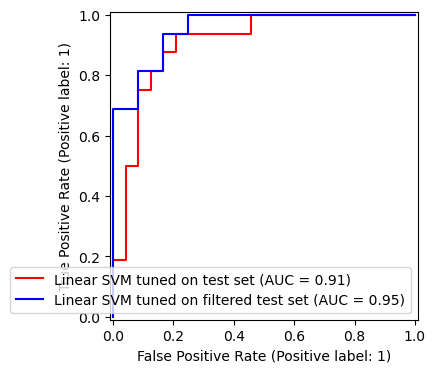

In [31]:
roc_curve = RocCurveDisplay.from_estimator  # shorthand
fig, ax = plt.subplots(figsize=(4, 4))
roc_curve(best_linear_mod, X_test, y_test, name="Linear SVM tuned on test set", ax=ax, color="r")
roc_curve(best_linear_mod_filtered, X_test_f, y_test_f, name="Linear SVM tuned on filtered test set", ax=ax, color="b");

## Polynomial SVM

Given the RBF kernel's previously demonstrated low accuracy, we re-evaluated it in this part of the analysis. The model, when fitted again, achieved an accuracy of 0.4, and even its cross-validation (CV) accuracy was only 0.455833, reaffirming its poor performance. Consequently, **we have decided to omit the RBF kernel from this section**.   
Luckly an overall increase in performance can be observed when using polynomial kernels.

In [32]:
svm_rbf_filtered = SVC(C=100, gamma=0.5, kernel="rbf")
svm_rbf_filtered.fit(X_train_f,y_train_f)
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gamma_range = [0.5, 1, 2, 3, 4]
kfold = skm.KFold(5, random_state=0, shuffle=True)
grid = skm.GridSearchCV(svm_rbf_filtered,
                        {"C": C_values, "gamma": gamma_range},
                        cv=kfold,
                        scoring="accuracy")
grid.fit(X_filtered,y)
#access the best parameter combination
print("Optimal rbf model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal rbf model:  SVC(C=0.001, gamma=0.5)
Cross-validation accuracy of optimal model:  0.45583333333333337


In [ ]:
best_rbf_svm_filtered = grid.best_estimator_
best_rbf_svm_filtered.fit(X_train_f,y_train_f)
ypred_rbf_filtered = best_rbf_svm_filtered.predict(X_test_f)
ypred_rbf_filtered
confusion_table(ypred_rbf_filtered, y_test_f)

Truth,-1,1
Predicted,,
-1,0,0
1,24,16


In [34]:
(ypred_rbf_filtered == y_test_f).mean() #accuracy

0.4

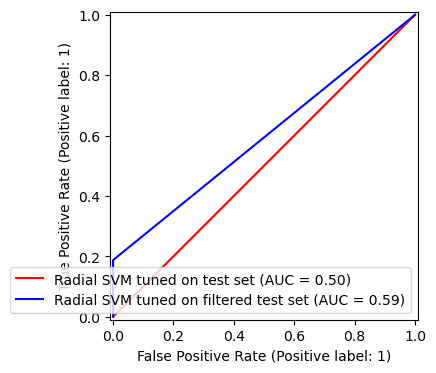

In [35]:
fig, ax = plt.subplots(figsize=(4, 4))
roc_curve(best_rbf_svm, X_test, y_test, name="Radial SVM tuned on test set", ax=ax, color="r")
roc_curve(best_rbf_svm_filtered, X_test_f, y_test_f, name="Radial SVM tuned on filtered test set", ax=ax, color="b");

In [36]:
svm_poly_filtered = SVC(C=100, degree=2, kernel="poly")
svm_poly_filtered.fit(X_train_f,y_train_f)
C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100]
degree_range = [1, 2, 3, 4]
kfold = skm.KFold(5, random_state=0, shuffle=True)
grid = skm.GridSearchCV(svm_poly_filtered,
                        {"C": C_values, "degree": degree_range},
                        cv=kfold,
                        scoring="accuracy") 
grid.fit(X_filtered,y)
print("Optimal polynomial model: ", grid.best_estimator_)
print("Cross-validation accuracy of optimal model: ", grid.best_score_)

Optimal polynomial model:  SVC(C=0.1, degree=2, kernel='poly')
Cross-validation accuracy of optimal model:  0.8208333333333334


In [ ]:
best_poly_svm_filtered = grid.best_estimator_
best_poly_svm_filtered.fit(X_train_f,y_train_f)
ypred_poly_filtered = best_poly_svm_filtered.predict(X_test_f)
ypred_poly_filtered
confusion_table(ypred_poly_filtered, y_test_f)

Truth,-1,1
Predicted,,
-1,17,0
1,7,16


In [38]:
(ypred_poly_filtered == y_test_f).mean() #accuracy

0.825

Polynomial SVM performs nearly identically to Linear SVM, achieving the same test accuracy. Both models also show identical AUC values across original and filtered datasets, indicating similar sample ranking ability.

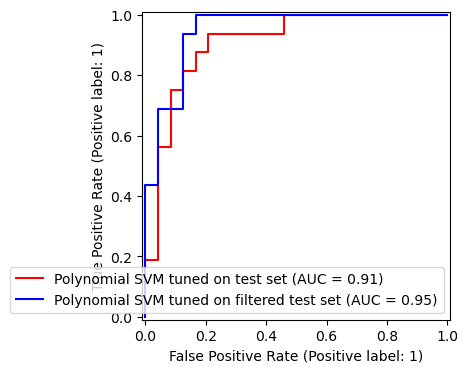

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
roc_curve(best_poly_svm, X_test, y_test, name="Polynomial SVM tuned on test set", ax=ax, color="r")
roc_curve(best_poly_svm_filtered, X_test_f, y_test_f, name="Polynomial SVM tuned on filtered test set", ax=ax, color="b");

# Conclusion

Theoretically, for gene expression data, characterized by high dimensionality and often a relatively small number of samples, **linear models** are frequently hypothesized to perform well. This is because they are less prone to overfitting in such scenarios compared to more complex models like RBF or high-degree Polynomial kernels, and can often find effective separating hyperplanes even when many features are present. Regularization (like the **C parameter** in SVMs) becomes critical to manage the high dimensionality and potential multicollinearity among genes. While non-linear kernels can capture more intricate relationships, they require careful tuning and are more susceptible to fitting noise, especially without robust feature selection that isolates genuinely interacting features.
This comparative analysis of SVM kernels on both the full and a 5% filtered gene expression dataset revealed distinct performance characteristics. The **Linear SVM** applied to the full dataset emerged as the optimal model, achieving the highest cross-validation accuracy of 0.8625 on the entirety of the dataset and 0.8339 to the filtered one. In contrast, the **RBF kernel** consistently underperformed, yielding low accuracies of 0.5416 on the full dataset and dropping further to 0.4558 on the filtered set, indicating persistent issues likely related to underfitting. The **Polynomial SVM** presented a notable improvement with feature selection, increasing its accuracy from 0.7 on the full dataset to 0.8208 on the filtered data.
Regarding the decrease in accuracy for the Linear SVM (and RBF) on the filtered dataset, this is somewhat counter-intuitive as feature selection is often beneficial. A possible explanation is that the 5% filtering process, while intended to reduce noise or dimensionality, may have inadvertently removed genes that, while perhaps not top-ranked individually by the filtering criterion, were collectively important for the linear model's discriminative power.  
For the Polynomial SVM, the improvement suggests it was likely overfitting on the high-dimensional full dataset, and feature reduction helped by simplifying the problem space, allowing its non-linear capabilities to find a better fit on the reduced, potentially more focused, feature set.
Overall, these results reinforce the idea that a **linear decision boundary** is sufficient for this classification task, and adding polynomial complexity does not substantially improve discrimination.
The optimal regularization parameter C for this best-performing Linear SVM (on the full dataset) was found to be 0.1. When the Linear SVM was applied to the filtered dataset, the optimal C value shifted to 0.01. This decrease in C for the filtered data suggests that a stronger regularization (larger margin, more tolerance for misclassifications) was favored when working with a reduced, potentially less noisy, feature set. Conversely, the slightly higher C on the full, high-dimensional dataset allowed the model more flexibility to find a separating hyperplane among a larger number of features.
